In [60]:
import torch
from torch import nn
from torchvision import models
import torch.nn.functional as F

from asclepius.models import custom_densenet
from asclepius.train import get_dataloaders

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt

In [2]:
weights_path = "output/aug_matched/densenet/PAUS/best_auc.pth"

In [3]:
model = custom_densenet(2)

In [4]:
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [5]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1):

In [6]:
model.features.conv0

Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [22]:
test_loader = get_dataloaders(mode="test")

INFO 2023-11-19 12:04:16,581 [root:train.py:get_dataloaders:38]
found dataset directory: /home/varun/xia_lab/repos/paus_2dcs/dataset/preprocessed/bal

INFO 2023-11-19 12:04:16,584 [root:data.py:__init__:67]
modalities: PAUS



In [23]:
test_batch = next(iter(test_loader))

In [24]:
test_input, test_label = test_batch

In [66]:
test_input.requires_grad = True

In [67]:
output = model(test_input)

In [68]:
prediction_score, pred_label_idx = torch.topk(output, 1)

## Integrated Gradients

In [69]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(test_input, target=pred_label_idx, n_steps=200)

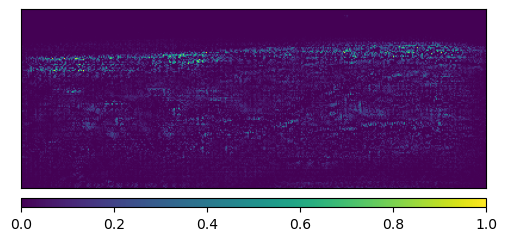

In [70]:
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(test_input.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="viridis",
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

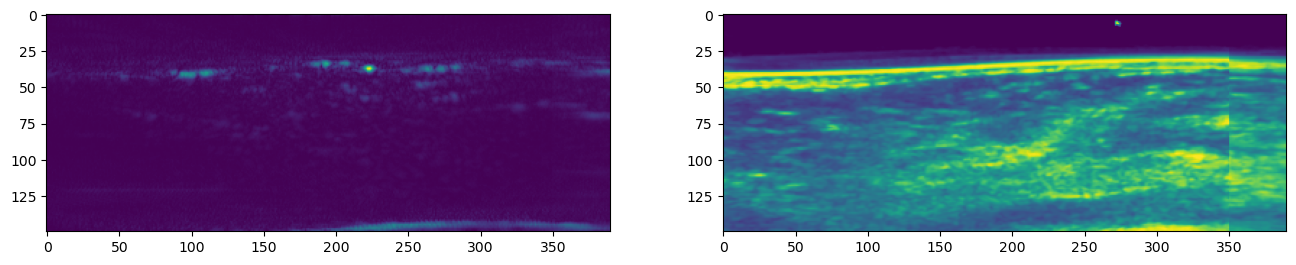

In [71]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(np.transpose(test_input.squeeze().cpu().detach().numpy(), (1,2,0))[:,:,0])
plt.subplot(1,2,2)
plt.imshow(np.transpose(test_input.squeeze().cpu().detach().numpy(), (1,2,0))[:,:,1])

## Noise Tunnel

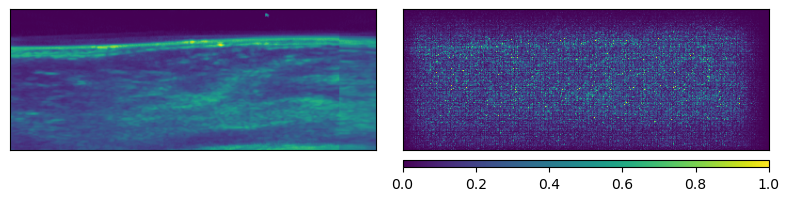

In [72]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(test_input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.mean(np.transpose(test_input.squeeze().cpu().detach().numpy(), (1,2,0)), axis=2),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap="viridis",
                                      show_colorbar=True)

## Gradient SHAP

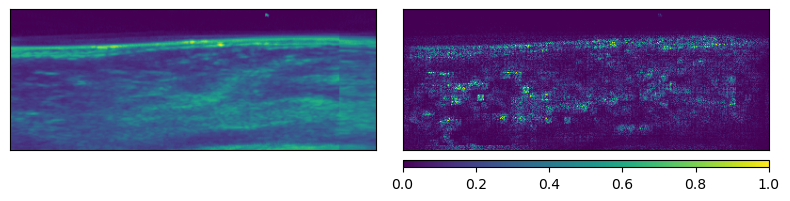

In [73]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([test_input * 0, test_input * 1])

attributions_gs = gradient_shap.attribute(test_input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.mean(np.transpose(test_input.squeeze().cpu().detach().numpy(), (1,2,0)), axis=2),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap="viridis",
                                      show_colorbar=True)

## Occlusion

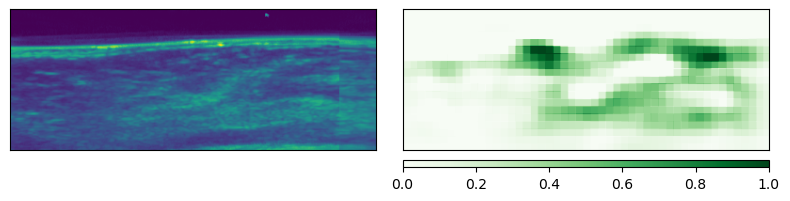

In [74]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(test_input,
                                       strides = (2, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(2,15, 15),
                                       baselines=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.mean(np.transpose(test_input.squeeze().cpu().detach().numpy(), (1,2,0)), axis=2),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

## Occlusion - Custom Size

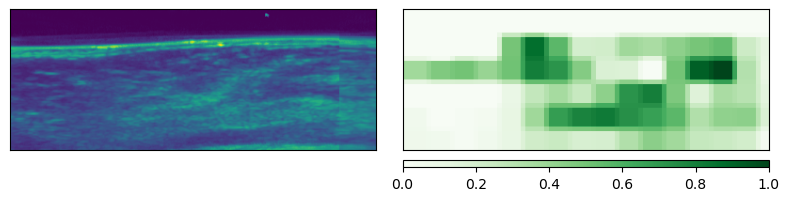

In [75]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(test_input,
                                       strides = (2, 25, 25),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(2, 30, 30),
                                       baselines=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.mean(np.transpose(test_input.squeeze().cpu().detach().numpy(), (1,2,0)), axis=2),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

## Layerwise Relevance Propagation (LRP)

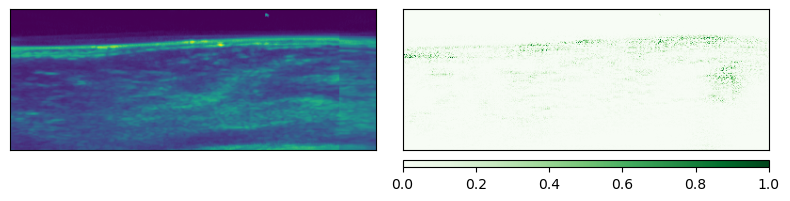

In [76]:
lrp = LRP(model)
attributions_lrp = lrp.attribute(test_input, target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.mean(np.transpose(test_input.squeeze().cpu().detach().numpy(), (1,2,0)), axis=2),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

### LRP With Custom Layer Rules

In [77]:
layers = list(model._modules["features"]) + list(model._modules["classifier"])
num_layers = len(layers)

In [78]:
num_layers

11

In [79]:
for idx_layer in range(1, num_layers):
    if idx_layer <= 5:
        setattr(layers[idx_layer], "rule", GammaRule())
    elif 17 <= idx_layer <= 8:
        setattr(layers[idx_layer], "rule", EpsilonRule())
    elif idx_layer >= 10:
        setattr(layers[idx_layer], "rule", EpsilonRule(epsilon=0))

lrp = LRP(model)
attributions_lrp = lrp.attribute(test_input, target=pred_label_idx)

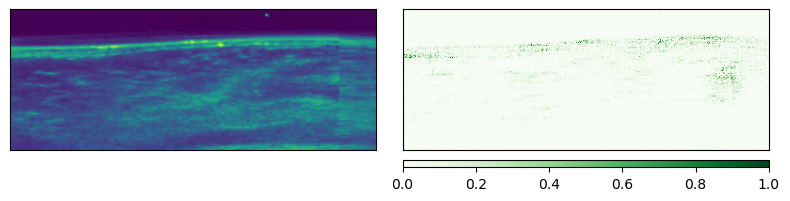

In [80]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.mean(np.transpose(test_input.squeeze().cpu().detach().numpy(), (1,2,0)), axis=2),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

## Saliency Map

In [81]:
saliency = Saliency(model)

In [82]:
attributions_saliency = saliency.attribute(test_input, target=pred_label_idx)

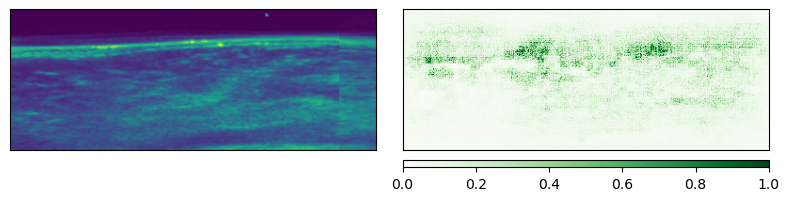

In [83]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_saliency.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.mean(np.transpose(test_input.squeeze().cpu().detach().numpy(), (1,2,0)), axis=2),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)